# Gathering of Bayesian evidence for the ELM model

In [1]:
import pickle
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from periodictable import elements

In [2]:
import exfor_tools
import jitr

Using database version x4i3_X4-2023-04-29 located in: /home/beyerk/mambaforge/envs/sage/lib/python3.11/site-packages/x4i3/data


In [336]:
from functools import reduce

import x4i3
from x4i3.exfor_column_parsing import (
    X4AddErrorBarsColumnPair,
    X4ColumnParser,
    X4HighMidLowColumnPair,
    X4IndependentColumnPair,
    angDistParserList,
    angDistUnits,
    angleParserList,
    baseDataKeys,
    condenseColumn,
    crossSectionUnits,
    csDataParserList,
    dataTotalErrorKeys,
    energyDistParserList,
    frameSuffix,
    incidentEnergyParserList,
    noUnits,
    nubarParserList,
    outgoingEnergyParserList,
    percentUnits,
    spectrumArgumentParserList,
    variableSuffix,
)
from x4i3.exfor_dataset import X4DataSet

In [3]:
db = exfor_tools.get_db()

In [4]:
# targets to consider
Ca48 = (48, 20)
Pb208 = (208, 82)

Zr90 = (90, 40)
Zr92 = (92, 40)

Sn112 = (112, 50)
Sn114 = (114, 50)
Sn116 = (116, 50)
Sn118 = (118, 50)
Sn120 = (120, 50)
Sn122 = (122, 50)
Sn124 = (124, 50)

targets = [Ca48, Zr90, Zr92, Sn112, Sn114, Sn116, Sn118, Sn120, Sn122, Sn124, Pb208]

In [5]:
measurements = dict([(t, []) for t in targets])

In [6]:
proton = (1, 1)
neutron = (1, 0)

In [7]:
QIAS = {}
QIAS[Ca48] = -7.182
QIAS[Zr90] = -11.901
QIAS[Zr92] = -11.796

QIAS[Sn112] = -14.019
QIAS[Sn114] = -13.940
QIAS[Sn116] = -13.861
QIAS[Sn118] = -13.728  # 0+ and 2+ levels within an MeV
QIAS[Sn120] = -13.667
QIAS[Sn122] = -13.667
QIAS[Sn124] = -13.596

QIAS[Pb208] = -18.826

In [8]:
ExIAS = {}
ExIAS[Ca48] = 6.6775
ExIAS[Zr90] = 5.008
ExIAS[Zr92] = 9.008

ExIAS[Sn120] = 10.204
ExIAS[Sn118] = 9.289


ExIAS[Pb208] = 15.164

In [9]:
# if the excitation energy is not reported, reconstruct it from CDE and masses
# also check values
for target in targets:
    if target in QIAS.keys():
        analog = (target[0], target[1] + 1)
        BE_target = jitr.utils.mass.binding_energy(*target)[0]
        BE_analog = jitr.utils.mass.binding_energy(*analog)[0]

        if target in ExIAS.keys():
            print(target, BE_analog - BE_target - ExIAS[target], QIAS[target])
        else:
            ExIAS[target] = -QIAS[target] + BE_analog - BE_target

(48, 20) -7.1811313615783 -7.182
(90, 40) -11.90186236158316 -11.901
(92, 40) -11.796580361579078 -11.796
(118, 50) -13.728485361581319 -13.728
(120, 50) -13.667454361590266 -13.667
(208, 82) -18.825214361534805 -18.826


In [10]:
for t in targets:
    if t not in QIAS:
        del t

In [11]:
analogs = {}
rxn_names = {}
for isotope in targets:
    analog = (isotope[0], isotope[1] + 1)
    analogs[isotope] = analog
    name_targ = str(elements[isotope[1]].symbol)
    name_analog = str(elements[analog[1]].symbol)
    rxn_name = f"$^{{{isotope[0]}}}${name_targ}(p,n)$^{{{analog[0]}}}${name_analog}"
    rxn_names[isotope] = rxn_name

In [12]:
rxn_names

{(48, 20): '$^{48}$Ca(p,n)$^{48}$Sc',
 (90, 40): '$^{90}$Zr(p,n)$^{90}$Nb',
 (92, 40): '$^{92}$Zr(p,n)$^{92}$Nb',
 (112, 50): '$^{112}$Sn(p,n)$^{112}$Sb',
 (114, 50): '$^{114}$Sn(p,n)$^{114}$Sb',
 (116, 50): '$^{116}$Sn(p,n)$^{116}$Sb',
 (118, 50): '$^{118}$Sn(p,n)$^{118}$Sb',
 (120, 50): '$^{120}$Sn(p,n)$^{120}$Sb',
 (122, 50): '$^{122}$Sn(p,n)$^{122}$Sb',
 (124, 50): '$^{124}$Sn(p,n)$^{124}$Sb',
 (208, 82): '$^{208}$Pb(p,n)$^{208}$Bi'}

# Let's find some data to calibrate to

Let's grab the excitation energies of the isobaric analog states from [here](https://www.sciencedirect.com/science/article/abs/pii/S0092640X97907403). Let's grab some data. We will go exfor entry by exfor entry, as (p,n) to the IAS is less simpe to extract automatically, as it's formatted inconsistently.

In [13]:
def get_pn_measurements(entries, measurements):
    for entry in entries:
        data_sets = db.retrieve(ENTRY=entry)[entry].getSimplifiedDataSets()
        for key, data_set in data_sets.items():
            isotope = (
                data_set.reaction[0].targ.getA(),
                data_set.reaction[0].targ.getZ(),
            )
            projectile = (
                data_set.reaction[0].proj.getA(),
                data_set.reaction[0].proj.getZ(),
            )
            quantity = data_set.reaction[0].quantity
            products = data_set.reaction[0].products
            q = data_set.reaction[0].quantity

            if q[0] == "PAR" and q[1] == "DA" and isotope in measurements:
                print(f"target: {isotope}")
                subm = exfor_tools.get_measurements_from_subentry(
                    [10, 200],
                    data_set,
                )

                if isotope in measurements:
                    for m in subm:
                        print(f"\tLab energy: {m.Elab} MeV")
                        measurements[isotope].append(m)
    return measurements

## [Doering et al., 1975, EXFOR O0178](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=240178)

In [14]:
entries = ["O0178"]
measurements = get_pn_measurements(entries, measurements)

target: (48, 20)
	Lab energy: 45.0 MeV
target: (48, 20)
	Lab energy: 35.0 MeV
target: (48, 20)
	Lab energy: 25.0 MeV
target: (90, 40)
	Lab energy: 45.0 MeV
target: (90, 40)
	Lab energy: 35.0 MeV
target: (90, 40)
	Lab energy: 25.0 MeV
target: (120, 50)
	Lab energy: 45.0 MeV
target: (120, 50)
	Lab energy: 35.0 MeV
target: (120, 50)
	Lab energy: 25.0 MeV
target: (208, 82)
	Lab energy: 45.0 MeV
target: (208, 82)
	Lab energy: 35.0 MeV
target: (208, 82)
	Lab energy: 25.0 MeV


In [319]:
0.0046 * 0.07

0.000322

In [379]:
s = db.retrieve(ENTRY="O0178")["O0178"].getDataSets()[("O0178", "O0178006", " ")]
s

Authors:   R.R.Doering, D.M.Patterson, A.Galonsky
Title:     Microscopic Description Of Isobaric-Analog-State Transitions Induced By 25,35 And 45 Mev Protons.
Year:      1975
Institute: Michigan State University, East Lansing, MI
Reference: Physical Review, Part C, Nuclear Physics 12, 378 (1975)
Subent:    O0178006 
Reaction:  (20-CA-48(P,N)21-SC-48,PAR,DA,EXP)
[['ERR-1','ERR-2','ERR-3','ERR-4','EN','Q-VAL','ANG-ERR','DATA-ERR','ANG-CM','DATA','ERR-T'],
['PER-CENT','PER-CENT','PER-CENT','PER-CENT','MEV','MEV','ADEG','PER-CENT','ADEG','MB/SR','PER-CENT'],
[10.0,5.0,5.0,5.0,45.0,-7.175,1.4,7.0,0.0,4.6,None],
[10.0,5.0,5.0,5.0,45.0,-7.175,1.4,7.0,9.2,2.99,None],
[10.0,5.0,5.0,5.0,45.0,-7.175,1.4,7.0,13.3,3.45,None],
[10.0,5.0,5.0,5.0,45.0,-7.175,1.4,7.0,19.5,5.1,None],
[10.0,5.0,5.0,5.0,45.0,-7.175,1.4,7.0,24.6,5.3,None],
[10.0,5.0,5.0,5.0,45.0,-7.175,1.4,7.0,29.7,4.6,None],
[10.0,5.0,5.0,5.0,45.0,-7.175,1.4,7.0,34.9,2.44,None],
[10.0,5.0,5.0,5.0,45.0,-7.175,1.4,7.0,41.0,1.5,20.0],
[10.0,

In [442]:
# TODO handle Rutherford, Ay, etc. [noUnits]
# TODO handle asymmetric error
def sanitize_column(col):
    for i in range(len(col)):
        if col[i] is None:
            col[i] = 0
    return col


def parse_diff_xs(
    subentry: x4i3.exfor_dataset.X4AngularDistributionDataSet,
    data_error_columns=None,
    err_treatment="independent",
):
    r"""
    Extracts angular differential cross sections, returning incident and product excitation
    energy in MeV, angles and error in angle in degrees, and differential cross section and its
    error in mb/Sr.
    """
    if subentry.referenceFrame != "Center of mass":
        raise NotImplementedError("Conversions from lab frame not implemented yet")

    if data_error_columns is None:
        data_error_columns = [b + "-ERR" for b in baseDataKeys] + dataTotalErrorKeys

    # parse angle
    angle = reduce(condenseColumn, [c.getValue(subentry) for c in angleParserList])
    if angle[1] != "degrees":
        raise ValueError(f"Cannot parse angle in units of {angle[1]}")
    angle = np.array(angle[2:])

    angle_err = reduce(condenseColumn, [c.getError(subentry) for c in angleParserList])
    if angle_err[1] != "degrees":
        raise ValueError(f"Cannot parse angle error in units of {angle_err[1]}")
    angle_err = np.array(angle_err[2:])

    # parse energy if it's present
    E_inc_cm = np.array(
        reduce(
            condenseColumn, [c.getValue(subentry) for c in incidentEnergyParserList]
        )[2:],
        dtype=np.float64,
    )
    E_inc_cm_err = np.array(
        reduce(
            condenseColumn, [c.getError(subentry) for c in incidentEnergyParserList]
        )[2:],
        dtype=np.float64,
    )

    # parse excitation energy if it's present
    # TODO
    E_ex = np.zeros_like(E_inc_cm)
    E_ex_err = np.zeros_like(E_inc_cm)

    # parse diff xs
    data_parser = X4ColumnParser(
        match_labels=reduce(
            lambda x, y: x + y,
            [[b + s for s in variableSuffix + frameSuffix] for b in baseDataKeys],
        ),
        match_units=angDistUnits,
    )
    iy = data_parser.firstMatch(subentry)
    data_column = data_parser.getColumn(iy, subentry)
    xs_units = data_column[1]
    xs = np.array(data_column[2:], dtype=np.float64)

    # parse errors
    err_col_match = []
    for label in data_error_columns:

        # parse error column
        err_parser = X4ColumnParser(
            match_labels=reduce(
                lambda x, y: x + y,
                [label],
            ),
            match_units=angDistUnits + percentUnits,
        )
        icol = err_parser.firstMatch(subentry)
        if icol > 0:
            err = err_parser.getColumn(icol, subentry)
            err_units = err[1]
            err_data = np.array(sanitize_column(err[2:]), dtype=np.float64)
            # convert to same units as data
            if "PER-CENT" in err_units:
                err_data *= xs / 100
            elif err_units != xs_units:
                raise ValueError(
                    f"Attempted to extract error column {err[0]} with incompatible units"
                    f"{err_units} for data column {data_column[0]} with units {xs_units}"
                )

            err_col_match.append(err_data)

    if not err_col_match:
        xs_err = np.zeros_like(xs)
    elif err_treatment == "independent":
        # sum errors in quadrature
        xs_err = np.sqrt(np.sum(np.array(err_col_match) ** 2, axis=0))
    elif err_treatment == "cumulative":
        # add errors
        xs_err = np.sum(np.array(err_col_match), axis=0)
    elif err_treatment == "difference":
        # subtract second error column from first
        if len(err_col_match) > 2:
            raise ValueError(
                f"Cannot only take difference of 2 error columns, but {len(err_col_match)} were found!"
            )
        xs_err = err_col_match[0] - err_col_match[1]

    # convert from b/Sr to mb/Sr
    xs *= 1000
    xs_err *= 1000

    return E_inc_cm, E_inc_cm_err, E_ex, E_ex_err, angle, angle_err, xs, xs_err

In [443]:
parse_diff_xs(s, data_error_columns=["ERR-T", "DATA-ERR"])

(array([45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
        45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0. ,   9.2,  13.3,  19.5,  24.6,  29.7,  34.9,  41. ,  45.1,
         51.3,  55.4,  60.5,  65.6,  70.8,  75.9,  81. ,  86.1,  91.3,
         96.4, 100.5, 110.8, 121. , 131.3, 140.5, 150.8]),
 array([1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
        1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]),
 array([4.6  , 2.99 , 3.45 , 5.1  , 5.3  , 4.6  , 2.44 , 1.5  , 1.18 ,
        1.01 , 1.17 , 0.62 , 0.33 , 0.19 , 0.176, 0.21 , 0.14 ,

In [316]:
X4DataSet.getSimplified(
    s,
    parserMap={
        "Energy": incidentEnergyParserList,
        "Angle": angleParserList,
        "Data": angDistParserList,
    },
    columnNames=["Energy", "Angle", "Data"],
)

Authors:   R.R.Doering, D.M.Patterson, A.Galonsky
Title:     Microscopic Description Of Isobaric-Analog-State Transitions Induced By 25,35 And 45 Mev Protons.
Year:      1975
Institute: Michigan State University, East Lansing, MI
Reference: Physical Review, Part C, Nuclear Physics 12, 378 (1975)
Subent:    O0178006 
Reaction:  (20-CA-48(P,N)21-SC-48,PAR,DA,EXP)
[['Energy','Angle','Data','d(Angle)','d(Data)'],
['MeV','degrees','barns/ster','degrees','barns/ster'],
[45.0,0.0,0.0046,1.4,0.000322],
[45.0,9.2,0.0029900000000000005,1.4,0.00020930000000000005],
[45.0,13.3,0.0034500000000000004,1.4,0.00024150000000000002],
[45.0,19.5,0.0050999999999999995,1.4,0.00035699999999999995],
[45.0,24.6,0.0053,1.4,0.000371],
[45.0,29.7,0.0046,1.4,0.000322],
[45.0,34.9,0.00244,1.4,0.00017079999999999998],
[45.0,41.0,0.0015,1.4,0.000105],
[45.0,45.1,0.00118,1.4,8.26e-05],
[45.0,51.3,0.00101,1.4,7.07e-05],
[45.0,55.4,0.00117,1.4,8.19e-05],
[45.0,60.5,0.00062,1.4,4.34e-05],
[45.0,65.6,0.00033,1.4,2.31e-05]

In [321]:
6e-05 * 0.07

4.2000000000000004e-06

## [Anderson et al., 1985, EXFOR C0134](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=120134)
 -  issue: reported uncertainties missing
 -  for this entry, we must select by hand subentries with the IAS transition

In [15]:
# for Anderson data at 134 and 160 MeV, the analog 0+ transition is given in two subentries
anderson134 = exfor_tools.get_measurements_from_subentry(
    [10, 200],
    db.retrieve(ENTRY="C0134")["C0134"].getSimplifiedDataSets()[
        ("C0134", "C0134002", " ")
    ],
)[0]

anderson160 = exfor_tools.get_measurements_from_subentry(
    [10, 200],
    db.retrieve(ENTRY="C0134")["C0134"].getSimplifiedDataSets()[
        ("C0134", "C0134004", " ")
    ],
)[0]

measurements[Ca48].append(anderson134)
measurements[Ca48].append(anderson160)

## [Carlson et al., 1975, EXFOR D0049](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=130049)

- EXFOR entries for Pb208, Sn120,118 report E_ex in the analog nucleus that is in disagreement with the CDE tables, and the authors left out Pb208 from their fit, so this work will be ignored.

## [Anderson et al., 1988, EXFOR T0193](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=290193)
- the excitation energies are only reported for Zr90,92, so we only take those two measurements

In [16]:
entries = ["T0193"]
measurements = get_pn_measurements(entries, measurements)

target: (90, 40)
	Lab energy: 18.0 MeV
	Lab energy: 25.0 MeV
target: (92, 40)
	Lab energy: 18.0 MeV
	Lab energy: 25.0 MeV


## [Schery et al., 1978, EXFOR O0138](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=240138)
- Issue: reported uncertainties not transcribed properly

In [17]:
entries = ["O0138"]
measurements = get_pn_measurements(entries, measurements)

target: (124, 50)
	Lab energy: 35.3 MeV
target: (116, 50)
	Lab energy: 35.3 MeV
target: (112, 50)
	Lab energy: 35.3 MeV
target: (208, 82)
	Lab energy: 25.8 MeV
target: (208, 82)
	Lab energy: 35.0 MeV
target: (208, 82)
	Lab energy: 45.0 MeV
target: (48, 20)
	Lab energy: 45.0 MeV


## [Woods et al., 1972, EXFOR T0294](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=290294)

In [18]:
entries = ["T0294"]
measurements = get_pn_measurements(entries, measurements)

target: (208, 82)
	Lab energy: 30.5 MeV


## [Batty et al., 1968, EXFOR O0090](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=240090)

In [19]:
entries = ["O0090"]
measurements = get_pn_measurements(entries, measurements)

target: (120, 50)
	Lab energy: 49.4 MeV
target: (208, 82)
	Lab energy: 49.4 MeV
target: (120, 50)
	Lab energy: 30.4 MeV
target: (208, 82)
	Lab energy: 30.4 MeV


## [Wong et al., 1972, EXFOR O0084](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=240084)
- experimental uncertainties missing

In [304]:
variableSuffix

['', '-DUMMY', '-ASSUM', '-MEAN', '-APRX']

In [305]:
frameSuffix

['-CM']

In [306]:
entry = "O0084"
s = db.retrieve(ENTRY=entry)[entry].getDataSets()[("O0084", "O0084030", " ")]
s

Authors:   C.Wong, J.D.Anderson, J.W.Mcclure, B.A.Pohl, J.J.Wesolowski
Title:     Measurements And Optical-Model Analyses Of Quasielastic (P,N) Reactions.
Year:      1972
Institute: Lawrence Livermore National Laboratory, Livermore, CA
Reference: Physical Review, Part C, Nuclear Physics 5, 158 (1972)
Subent:    O0084030 
Reaction:  (40-ZR-90(P,N)41-NB-90,PAR,DA,A)
[['IAS-NUMB','ERR-1','EN','ANG-ERR-D','ANG-CM','DATA-CM','-DATA-ERR','+DATA-ERR'],
['NO-DIM','PER-CENT','MEV','ADEG','ADEG','MB/SR','PER-CENT','PER-CENT'],
[0.0,7.0,19.7,0.7,3.2,4.9,6.0,8.0],
[0.0,7.0,19.7,0.7,16.5,2.7,10.0,10.0],
[0.0,7.0,19.7,0.7,32.8,1.72,16.0,19.0],
[0.0,7.0,19.7,0.7,46.7,1.35,16.0,19.0],
[0.0,7.0,19.7,0.7,60.8,0.72,21.0,19.0],
[0.0,7.0,19.7,0.7,77.6,0.25,60.0,70.0],
[0.0,7.0,19.7,0.7,91.4,0.48,30.0,25.0],
[0.0,7.0,19.7,0.7,107.3,0.18,None,90.0],
[0.0,7.0,19.7,0.7,123.4,0.3,60.0,60.0],
[0.0,7.0,19.7,0.7,135.1,0.18,None,100.0]]

In [307]:
angDistUnits

['B/SR', 'MB/SR', 'MICRO-B/SR', 'barns/SR']

In [308]:
baseDataKeys

['DATA', 'RATIO']

In [309]:
X4ColumnParser(
    match_labels=reduce(
        lambda x, y: x + y,
        [[b + s for s in variableSuffix + frameSuffix] for b in baseDataKeys],
    ),
    match_units=angDistUnits + noUnits,
).firstMatch(s)

5

In [311]:
X4AddErrorBarsColumnPair(
    X4ColumnParser(
        match_labels=reduce(
            lambda x, y: x + y,
            [[b + s for s in variableSuffix + frameSuffix] for b in baseDataKeys],
        ),
        match_units=angDistUnits + noUnits,
    ),
    X4ColumnParser(
        match_labels=["-" + b + "-ERR" for b in baseDataKeys],
        match_units=angDistUnits + percentUnits,
    ),
    X4ColumnParser(
        match_labels=["+" + b + "-ERR" for b in baseDataKeys],
        match_units=angDistUnits + percentUnits,
    ),
).getValue(s)

['DATA-CM',
 'barns/ster',
 0.004900000000000001,
 0.0027,
 0.00172,
 0.00135,
 0.0007199999999999999,
 0.00025,
 0.00048,
 0.00017999999999999998,
 0.0003,
 0.00017999999999999998]

In [312]:
X4AddErrorBarsColumnPair(
    X4ColumnParser(
        match_labels=reduce(
            lambda x, y: x + y,
            [[b + s for s in variableSuffix + frameSuffix] for b in baseDataKeys],
        ),
        match_units=angDistUnits + noUnits,
    ),
    X4ColumnParser(
        match_labels=["-" + b + "-ERR" for b in baseDataKeys],
        match_units=angDistUnits + percentUnits,
    ),
    X4ColumnParser(
        match_labels=["+" + b + "-ERR" for b in baseDataKeys],
        match_units=angDistUnits + percentUnits,
    ),
).getError(s)

['ERR',
 'barns/ster',
 0.0004900000000000001,
 0.00038183766184073575,
 0.0004272391367840732,
 0.00033533304340610396,
 0.00020390115252249063,
 0.0002304886114323222,
 0.00018744599222175973,
 0.00016199999999999998,
 0.0002545584412271571,
 0.00017999999999999998]

In [221]:
s.units

['NO-DIM', 'PER-CENT', 'MEV', 'ADEG', 'ADEG', 'MB/SR', 'PER-CENT', 'PER-CENT']

In [219]:
s.labels

['IAS-NUMB',
 'ERR-1',
 'EN',
 'ANG-ERR-D',
 'ANG-CM',
 'DATA-CM',
 '-DATA-ERR',
 '+DATA-ERR']

In [297]:
def parse_diff_xs(data, labels, units):
    data = np.array(data)

In [314]:
X4DataSet.getSimplified(
    s,
    parserMap={
        "Energy": incidentEnergyParserList,
        "Angle": angleParserList,
        "Data": angDistParserList,
    },
    columnNames=["Energy", "Angle", "Data"],
)

Authors:   C.Wong, J.D.Anderson, J.W.Mcclure, B.A.Pohl, J.J.Wesolowski
Title:     Measurements And Optical-Model Analyses Of Quasielastic (P,N) Reactions.
Year:      1972
Institute: Lawrence Livermore National Laboratory, Livermore, CA
Reference: Physical Review, Part C, Nuclear Physics 5, 158 (1972)
Subent:    O0084030 
Reaction:  (40-ZR-90(P,N)41-NB-90,PAR,DA,A)
[['Energy','Angle','Data'],
['MeV','degrees','barns/ster'],
[19.7,3.2,0.004900000000000001],
[19.7,16.5,0.0027],
[19.7,32.8,0.00172],
[19.7,46.7,0.00135],
[19.7,60.8,0.0007199999999999999],
[19.7,77.6,0.00025],
[19.7,91.4,0.00048],
[19.7,107.3,0.00017999999999999998],
[19.7,123.4,0.0003],
[19.7,135.1,0.00017999999999999998]]

In [166]:
entry = "14317"
db.retrieve(ENTRY=entry)[entry].getDataSets()[("14317", "14317002", " ")]

'Center of mass'

In [132]:
db.retrieve(ENTRY=entry)[entry].getSimplifiedDataSets()[("O0084", "O0084002", " ")]

Authors:   C.Wong, J.D.Anderson, J.W.Mcclure, B.A.Pohl, J.J.Wesolowski
Title:     Measurements And Optical-Model Analyses Of Quasielastic (P,N) Reactions.
Year:      1972
Institute: Lawrence Livermore National Laboratory, Livermore, CA
Reference: Physical Review, Part C, Nuclear Physics 5, 158 (1972)
Subent:    O0084002 
Reaction:  (22-TI-48(P,N)23-V-48,PAR,DA,A)
[['Energy','Angle','Data'],
['MeV','degrees','barns/ster'],
[17.1,25.0,0.00134],
[17.1,39.9,0.00061],
[17.1,55.4,0.00049],
[17.1,69.9,0.00084],
[17.1,85.4,0.00062],
[17.1,100.1,0.0005300000000000001],
[17.1,112.9,0.0008],
[17.1,130.1,0.00073],
[17.1,155.8,0.00111]]

In [189]:
db.retrieve(ENTRY="C0134")["C0134"].getDataSets()["C0134", "C0134004", " "]

Authors:   B.D.Anderson, T.Chittrakarn, A.R.Baldwin, C.Lebo, R.Madey, R.J.Mccarthy, J.W.Watson, B.A.Brown, C.C.Foster
Title:     Particle-Hole Strength Excited In The 48Ca(P,N)48Sc Reaction At 134 And 160 Mev: Pi F(7/2), Nu F-1(7/2) Band
Year:      1985
Institute: Michigan State University, East Lansing, MI
Reference: Physical Review, Part C, Nuclear Physics 31, 1147 (1985); Physical Review, Part C, Nuclear Physics 31, 1161 (1985)
Subent:    C0134004 
Reaction:  (20-CA-48(P,N)21-SC-48,PAR,DA)
[['ERR-SYS','ERR-1','ERR-2','ERR-3','ERR-4','ERR-5','EN','E-EXC','ANG-CM','DATA-CM','ERR-S'],
['PER-CENT','PER-CENT','PER-CENT','PER-CENT','PER-CENT','PER-CENT','MEV','MEV','ADEG','MB/SR','MB/SR'],
[12.0,10.0,5.0,5.0,2.0,1.0,160.0,6.67,0.0,5.0,None],
[12.0,10.0,5.0,5.0,2.0,1.0,160.0,6.67,3.313,3.582,None],
[12.0,10.0,5.0,5.0,2.0,1.0,160.0,6.67,6.64,1.794,None],
[12.0,10.0,5.0,5.0,2.0,1.0,160.0,6.67,9.636,0.8063,None],
[12.0,10.0,5.0,5.0,2.0,1.0,160.0,6.67,12.035,0.394,None],
[12.0,10.0,5.0,5.0,2.0

In [20]:
entries = ["O0084"]
measurements = get_pn_measurements(entries, measurements)

target: (90, 40)
	Lab energy: 18.0 MeV
target: (90, 40)
	Lab energy: 19.7 MeV


## [Jon et al., 2000, EXFOR E2092](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=142092)

In [21]:
entries = ["E2092"]
measurements = get_pn_measurements(entries, measurements)

target: (92, 40)
	Lab energy: 35.0 MeV
target: (116, 50)
	Lab energy: 35.0 MeV
target: (120, 50)
	Lab energy: 35.0 MeV
target: (208, 82)
	Lab energy: 35.0 MeV


## [Schery et al., 1974, EXFOR  O0048](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=240048)
- unreported errors, lab system angles ignore

In [209]:
# entries = ["O0048"]
# measurements = get_pn_measurements(entries, measurements)

# Plot data

In [23]:
all_qepn_measurements = {}
for isotope in targets:
    all_qepn_measurements[isotope] = exfor_tools.sort_measurement_list(
        measurements[isotope]
    )

In [107]:
def plot_measurements(
    measurements,
    title,
    constant_factor=20,
    figsize=(6, 10),
    xlim=[-20, 190],
    label_offset_fraction=[0.75, 0.5],
):
    ylabel = r"$d\sigma/d\Omega$ [mb/Sr]"

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    n = 0
    for i, measurement in enumerate(measurements):
        offset = constant_factor**n
        n += 1

        # plot experiment
        x, x_err, y, y_err = (
            measurement.data[0, :],
            measurement.data[1, :],
            measurement.data[2, :],
            measurement.data[3, :],
        )
        p = ax.errorbar(
            x,
            offset * y,
            yerr=offset * y_err,
            # xerr=x_err,
            marker="s",
            markersize=2,
            #            color='none',
            alpha=0.6,
            linestyle="none",
            linewidth=4,
            #  color="k",
        )
        # add a label
        energy = str(measurement.Elab)

        if x[0] > 15 and x[-1] > 170:
            xloc = -18
            yloc = np.mean(y)
        elif x[-1] < 140:
            xloc = 150
            yloc = np.mean(y)
        else:
            xloc = -18
            yloc = np.mean(y)

        plt.text(xloc, yloc * offset, f"{energy} MeV", color=p.lines[0].get_color())

    ax.set_xlim(xlim)

    # plt.ylim([1, 1e6])
    plt.title(title)
    plt.yscale("log")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r"$\theta$ [deg]")

In [108]:
measurements.keys()

dict_keys([(48, 20), (90, 40), (92, 40), (112, 50), (114, 50), (116, 50), (118, 50), (120, 50), (122, 50), (124, 50), (208, 82)])

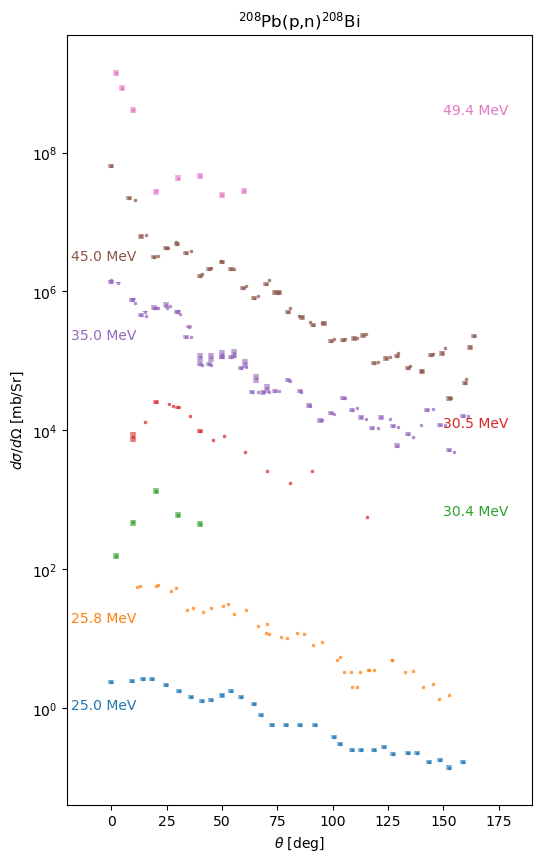

In [109]:
plot_measurements(
    all_qepn_measurements[Pb208],
    rxn_names[Pb208],
    constant_factor=20,
)

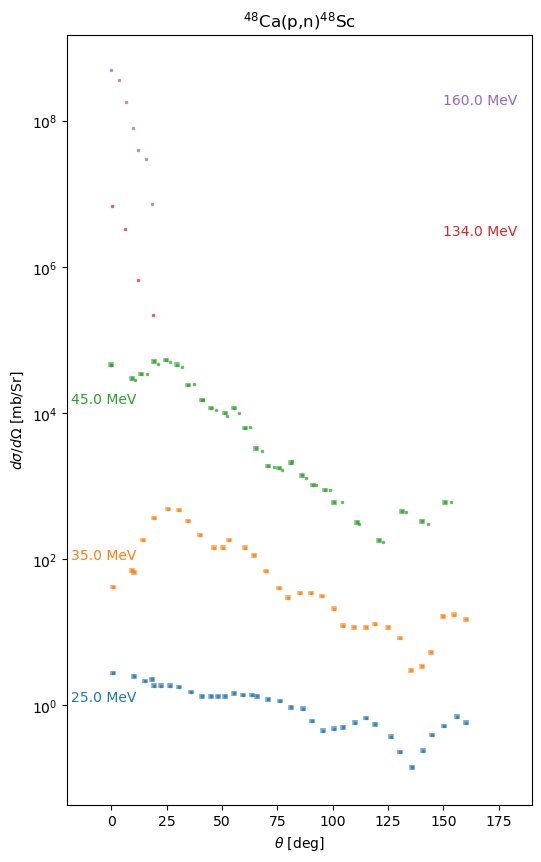

In [110]:
plot_measurements(
    all_qepn_measurements[Ca48],
    rxn_names[Ca48],
    constant_factor=100,
)

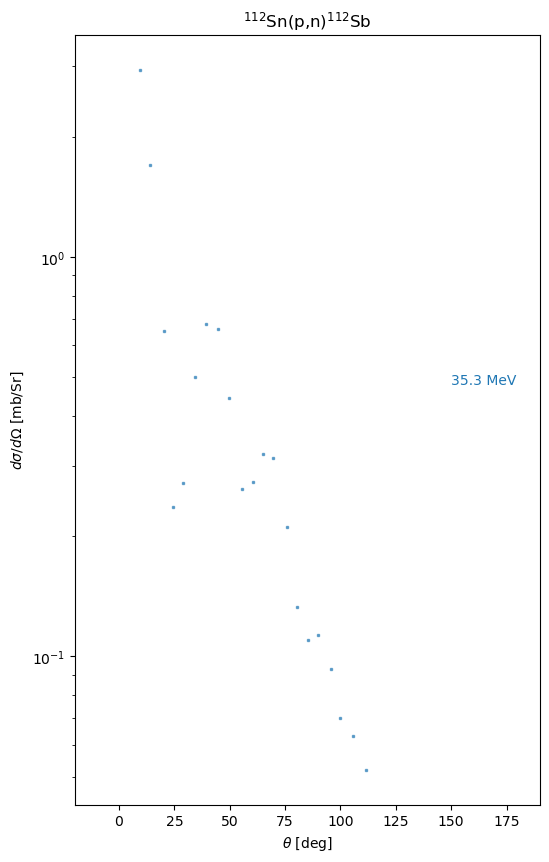

In [111]:
plot_measurements(
    all_qepn_measurements[Sn112],
    rxn_names[Sn112],
    constant_factor=20,
)

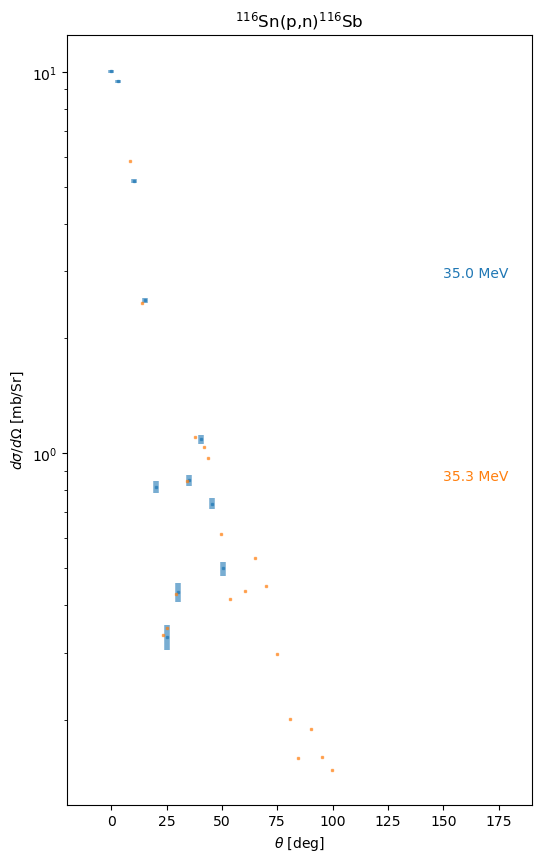

In [112]:
plot_measurements(
    all_qepn_measurements[Sn116],
    rxn_names[Sn116],
    constant_factor=1,
)

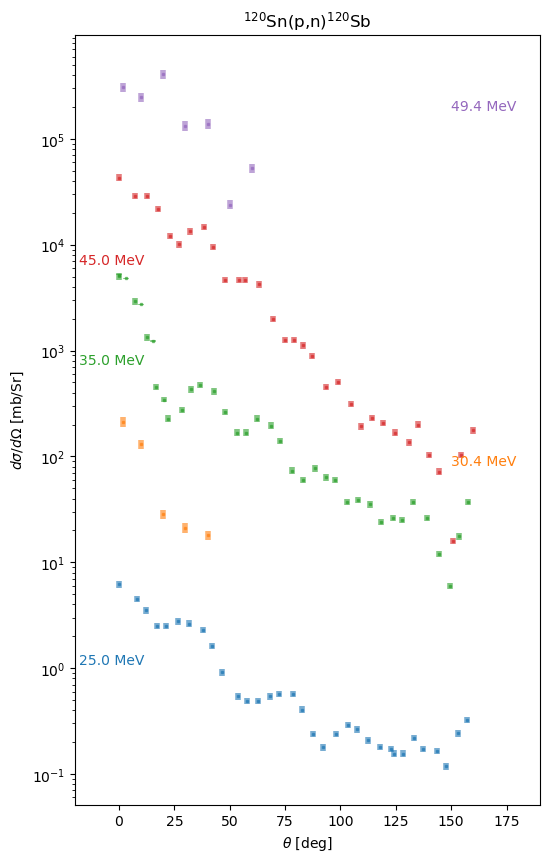

In [113]:
plot_measurements(
    all_qepn_measurements[Sn120],
    rxn_names[Sn120],
    constant_factor=20,
)

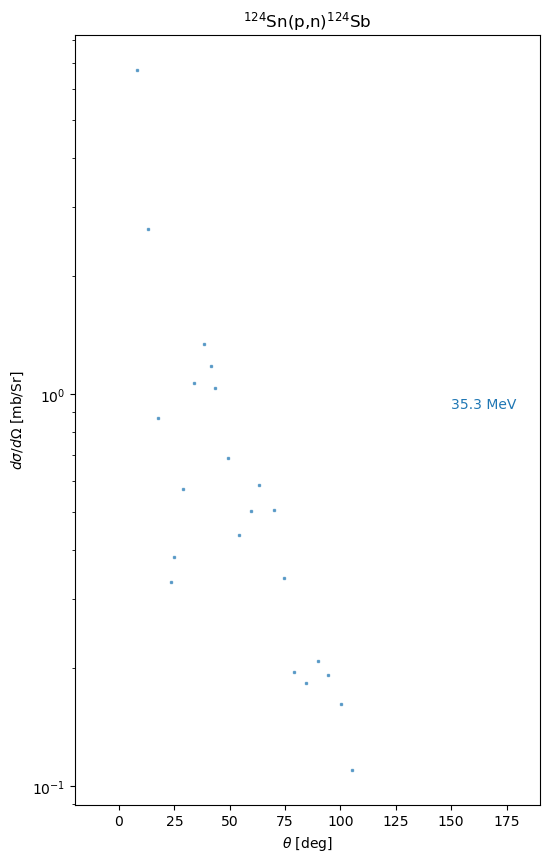

In [114]:
plot_measurements(
    all_qepn_measurements[Sn124],
    rxn_names[Sn124],
    constant_factor=20,
)

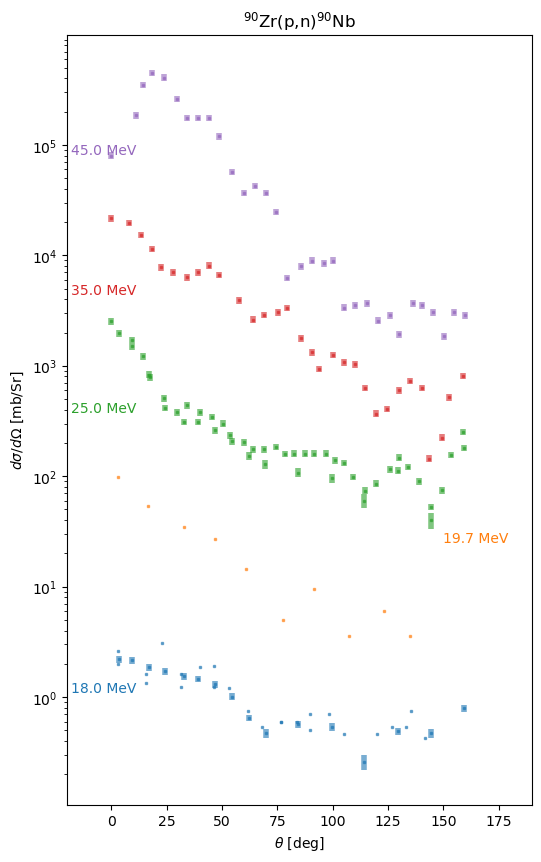

In [115]:
plot_measurements(
    all_qepn_measurements[Zr90],
    rxn_names[Zr90],
    constant_factor=20,
)

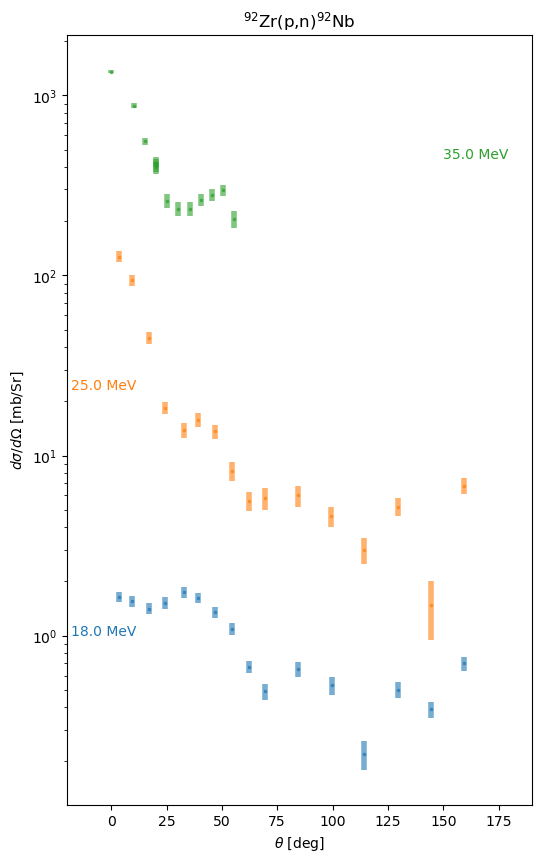

In [116]:
plot_measurements(
    all_qepn_measurements[Zr92],
    rxn_names[Zr92],
    constant_factor=20,
)

## Write data to disk

## Set up solvers for each isotope and energy
For each measurement, we will set up one solver for calibration, and one solver for visualization. These will use different angular grids.

In [47]:
core_solver = jitr.rmatrix.Solver(40)
channel_radius_fm = 20
lmax = 20
theta_vis = np.linspace(0.001, np.pi, 180)

In [48]:
def set_up_solver(target, Elab, Eias, angles_cal, angles_vis):
    analog = (target[0], target[1] + 1)
    kinp, kinn, Elab_n, Q, CDE = jitr.xs.quasielastic_pn.kinematics(
        target,
        analog,
        Elab,
        Eias,
    )
    sys = jitr.xs.quasielastic_pn.System(
        channel_radius_fm=channel_radius_fm,
        lmax=30,
        target=target,
        analog=analog,
        mass_target=jitr.utils.kinematics.mass(*target),
        mass_analog=jitr.utils.kinematics.mass(*analog),
        kp=kinp.k,
        kn=kinn.k,
    )
    workspace = jitr.xs.quasielastic_pn.Workspace(
        sys,
        kinp,
        kinn,
        Elab,
        Elab_n,
        core_solver,
        angles=angles_cal,
        tmatrix_abs_tol=1.0e-12,
    )
    workspace_vis = jitr.xs.quasielastic_pn.Workspace(
        sys,
        kinp,
        kinn,
        Elab,
        Elab_n,
        core_solver,
        angles=angles_vis,
        tmatrix_abs_tol=1.0e-12,
    )

    return workspace, workspace_vis

In [49]:
build_all_solvers = False
ws_dir = Path("./workspaces/")

if build_all_solvers:
    workspaces = {}
    for isotope in tqdm(isotopes):
        workspaces[isotope] = []

        for measurement in all_qepn_measurements[isotope]:
            theta = measurement.data[0, :] * np.pi / 180
            Elab = measurement.Elab
            workspaces[isotope].append(
                set_up_solver(isotope, Elab, ExIAS[isotope], theta, theta_vis)
            )

    for isotope in tqdm(isotopes):
        for i, measurement in enumerate(all_qepn_measurements[isotope]):
            Elab = measurement.Elab

            solver_cal, solver_vis = workspaces[isotope][i]
            solver_cal.save(
                ws_dir / f"workspace_A_{isotope[0]}_Z_{isotope[1]}_qepn_E_{i}.pickle"
            )
            solver_vis.save(
                ws_dir
                / f"vis_workspace_A_{isotope[0]}_Z_{isotope[1]}_qepn_E_{i}.pickle"
            )

            assert np.all(solver_cal.angles == measurement.data[0, :] * np.pi / 180)
else:
    workspaces = {}
    for isotope in tqdm(isotopes):
        workspaces[isotope] = []
        for i, measurement in enumerate(all_qepn_measurements[isotope]):
            Elab = measurement.Elab

            solver_cal = jitr.xs.quasielastic_pn.Workspace.load(
                ws_dir / f"workspace_A_{isotope[0]}_Z_{isotope[1]}_qepn_E_{i}.pickle"
            )
            solver_vis = jitr.xs.quasielastic_pn.Workspace.load(
                ws_dir
                / f"vis_workspace_A_{isotope[0]}_Z_{isotope[1]}_qepn_E_{i}.pickle"
            )
            workspaces[isotope].append((solver_cal, solver_vis))

NameError: name 'tqdm' is not defined

In [ ]:
pn_num = 0
pn_num_meas = 0
for isotope in isotopes:
    name = str(elements[isotope[1]].symbol)

    num = np.array([m.data.shape[1] for m in all_qepn_measurements[isotope]])
    pn_num += np.sum(num)
    pn_num_meas += num.shape[0]
    print(f"{np.sum(num)} data points in {num.shape[0]} data sets")

    Ep = [m.Elab for m in all_qepn_measurements[isotope]]
    plt.hist(Ep)
    plt.title(f"$^{{{isotope[0]}}}${name} $(p,n)$ data sets")
    plt.xlabel(r"$E_{lab}$ [Mev]")
    plt.show()

In [ ]:
print(f"In total {pn_num} data points in {pn_num_meas} sets for (p,n)")